In [1]:
from collections import Counter

# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import EditedNearestNeighbours, NearMiss
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.metrics import geometric_mean_score

In [2]:
def create_dataset(n_samples=5000, weights = (0.5,0.5), n_classes=2,
                   class_sep=0.01, n_clusters = 2):
    return make_classification(n_samples=n_samples, n_features=2,
                               n_informative=2, n_redundant=0, n_repeated=0,
                               n_classes=n_classes, 
                               flip_y = 0.1,
                               n_clusters_per_class=n_clusters,
                               weights=list(weights),
                               class_sep=class_sep, random_state=0)

In [3]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [4]:
def plot_decision_function(X, y, clf, ax):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')

In [5]:
#Membuat toy dataset

from sklearn.model_selection import train_test_split
X, y = create_dataset (n_samples=5000, weights = (0.8, 0.2), class_sep=0.5)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

# X_train = X_train.values
# y_train = y_train.values
# X_test = X_test.values
# y_test = y_test.values
print (X_train.shape)
print (X_test.shape)
print ("Komponen dataset sebelum undersampling = {}" .format(Counter(y)))

#Undersampling Dataset
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')
# sampler = NearMiss()
X_enn, y_enn = sampler.fit_resample (X_train , y_train)
print (X_enn.shape)
#Train dataset dengan classifier
clf_logreg = LogisticRegression(C=0.1, penalty='l2', solver='sag')
clf_logreg.fit(X_enn,y_enn)

clf_knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn.fit(X_enn, y_enn)

clf_svm = SVC(gamma=2, C=1)
clf_svm.fit(X_enn, y_enn)

clf_dt = DecisionTreeClassifier(max_depth=5, criterion='entropy')
clf_dt.fit(X_enn, y_enn)

clf_rf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf.fit(X_enn, y_enn)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn)))
    
print ("Komponen training set = {}" .format(Counter(y_train)))
print ("Komponen testing set = {}" .format(Counter(y_test)))


(4000, 2)
(1000, 2)
Komponen dataset sebelum undersampling = Counter({0: 3840, 1: 1160})
(3049, 2)
Komponen dataset setelah undersampling = Counter({0: 2122, 1: 927})
Komponen training set = Counter({0: 3073, 1: 927})
Komponen testing set = Counter({0: 767, 1: 233})



^
Expected {'graph' | 'digraph'} (at char 0), (line:1, col:1)


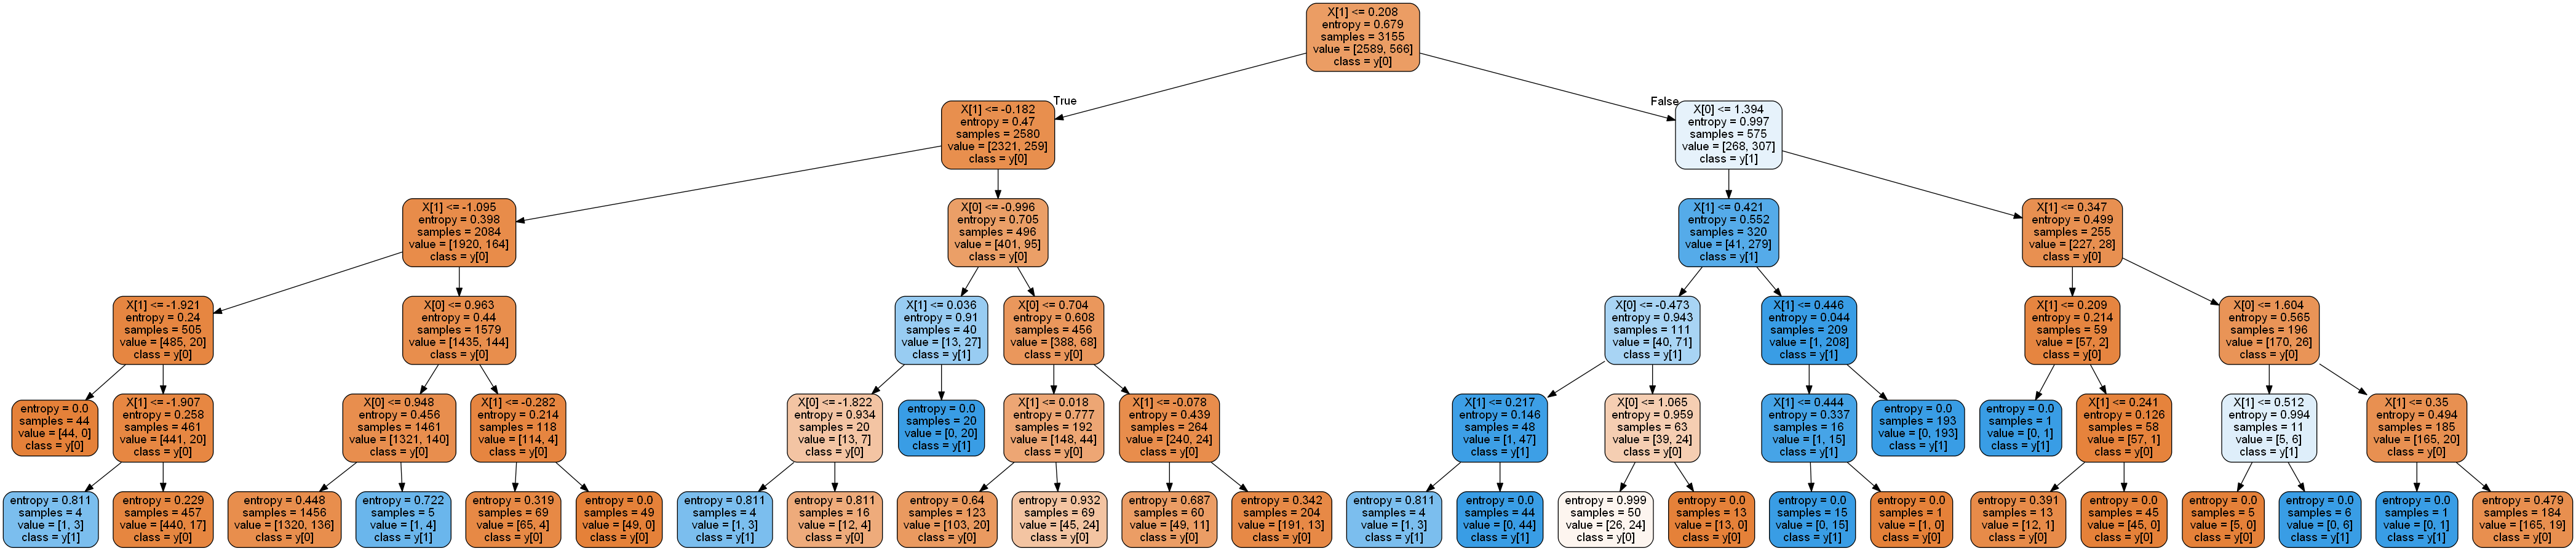

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz (clf_dt, out_file='create_dataset_with_noise_enn.dot',
                  class_names=True,
                rounded=True, proportion=False, precision=3, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(filename = 'create_dataset_with_noise_enn.png')

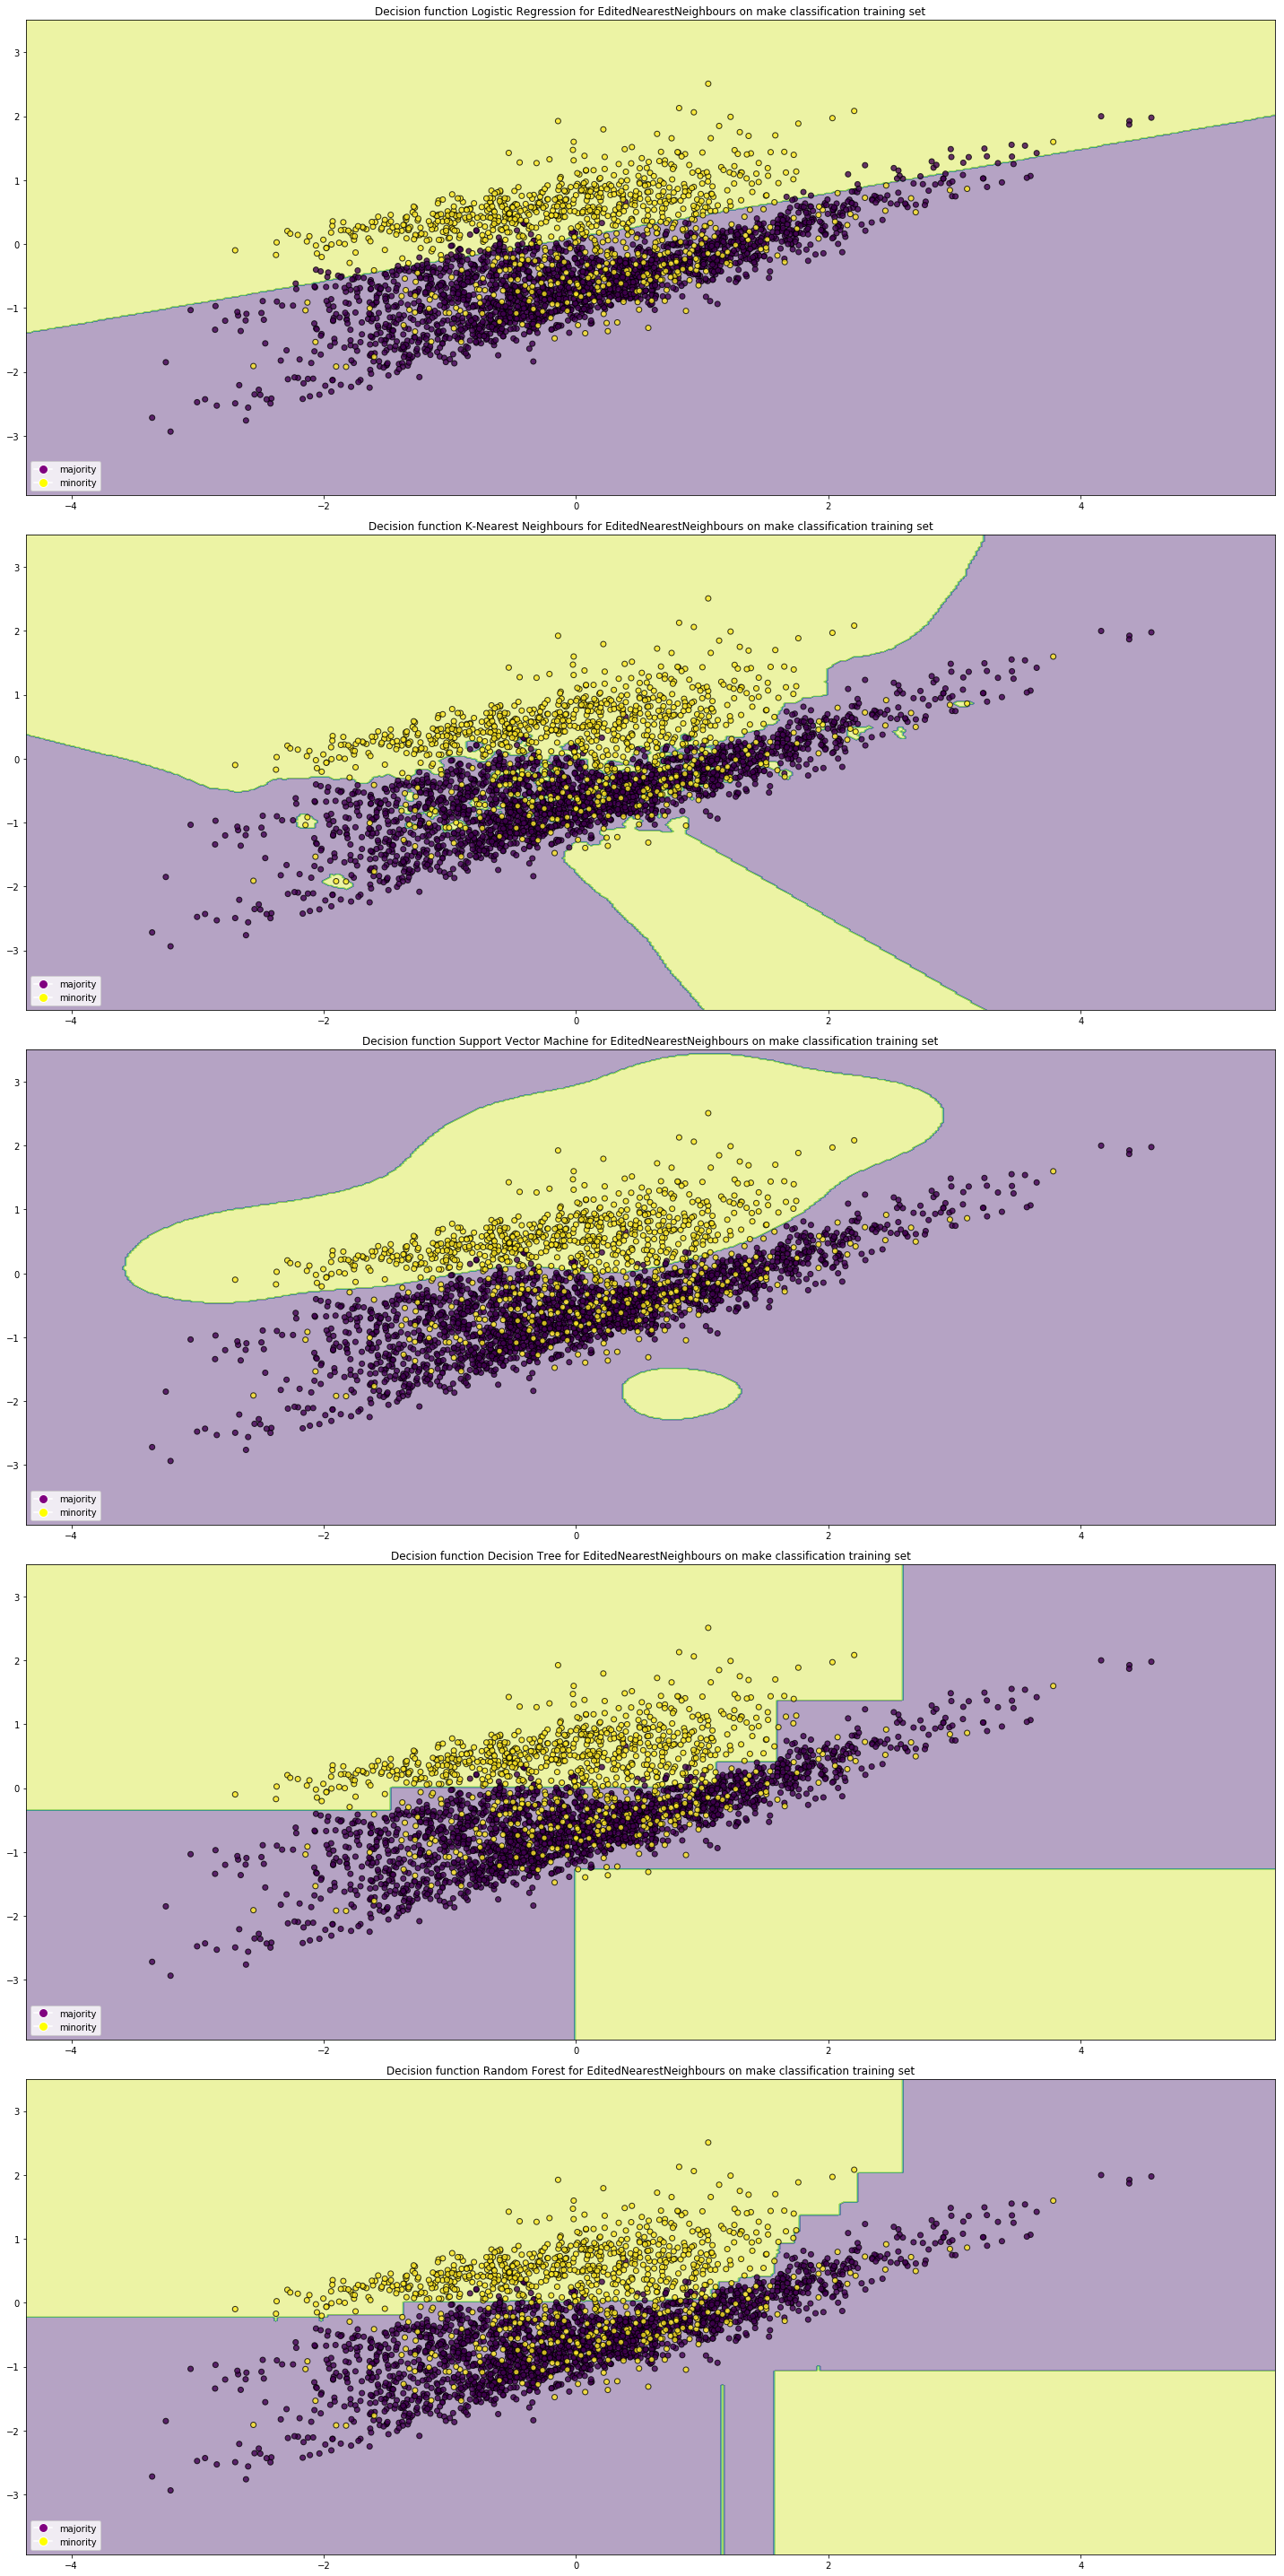

In [7]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf)):
#     clf = make_pipeline (sampler, classifier)
    classifier.fit(X_enn,y_enn)
    
    plot_decision_function(X_enn, y_enn, classifier, ax)
    ax.set_title('Decision function {} for {} on make classification training set'.format(name,
        sampler.__class__.__name__))
    majority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
fig.tight_layout()
plt.savefig("decision function make classification training set with enn.pdf")
# plt.show()

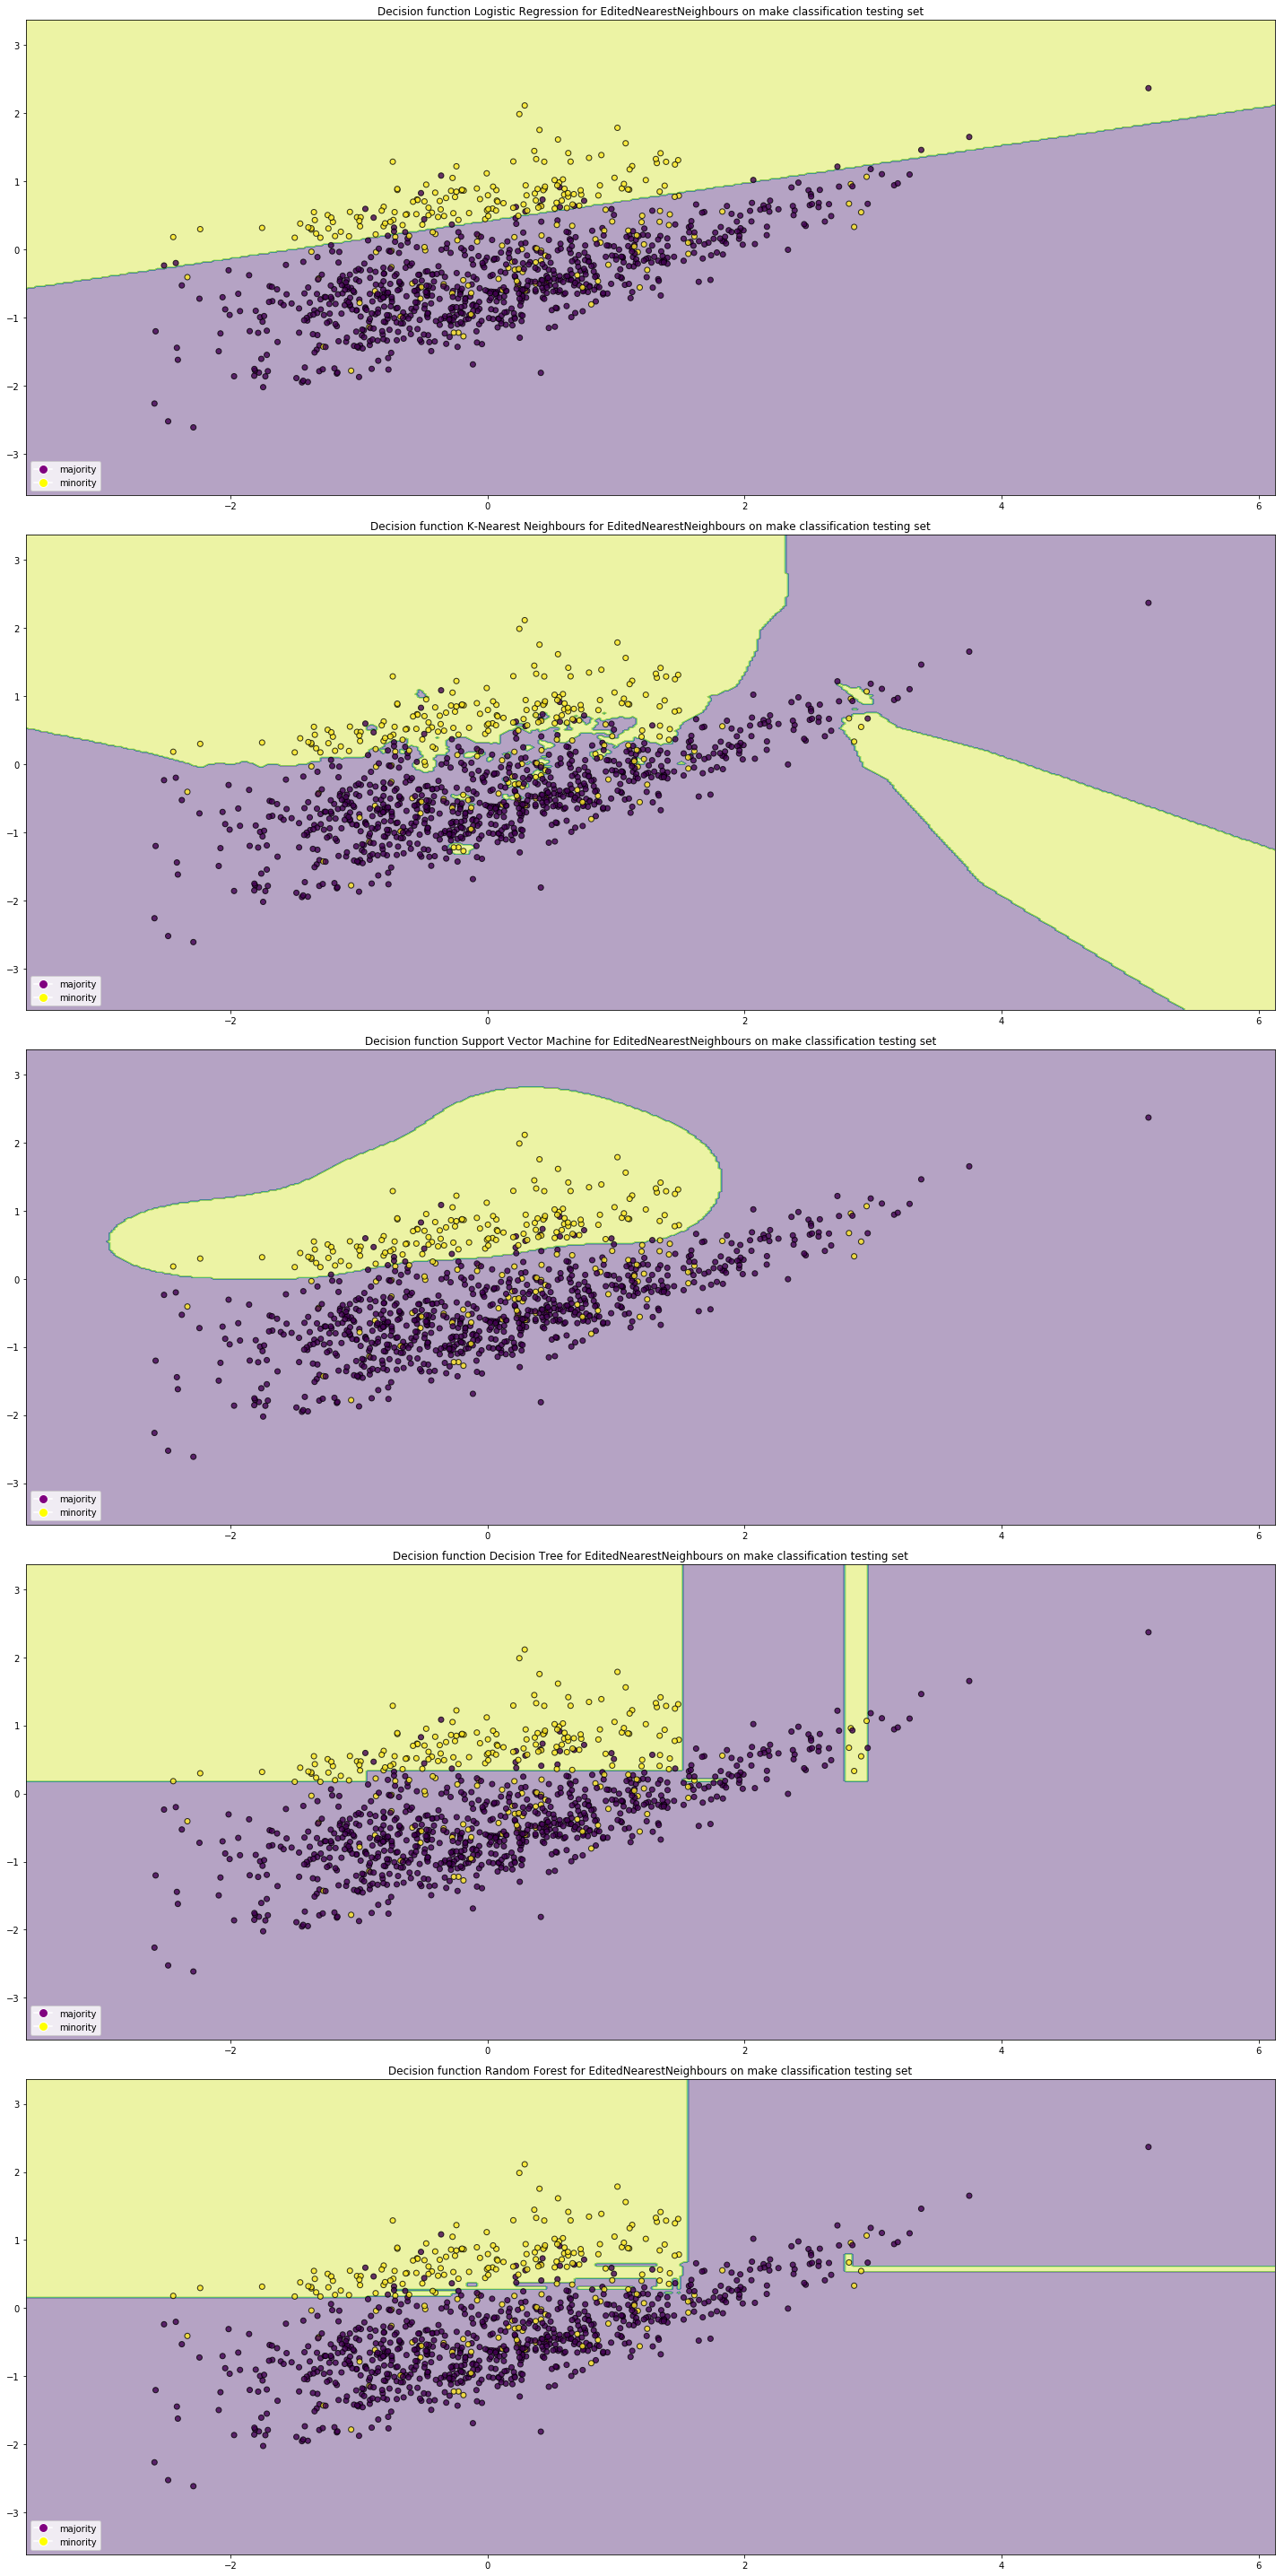

In [8]:
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf)):
#     clf = make_pipeline (sampler, classifier)
    classifier.fit(X_test,y_test)
    
    plot_decision_function(X_test, y_test, classifier, ax)
    ax.set_title('Decision function {} for {} on make classification testing set'.format(name,
        sampler.__class__.__name__))
    majority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
fig.tight_layout()
plt.savefig("decision function make classification testing set with enn.pdf")

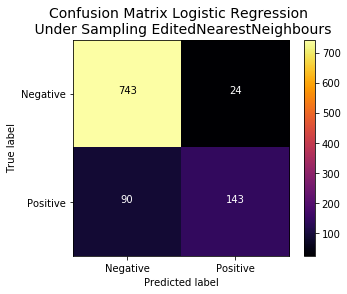

In [9]:
from sklearn.metrics import confusion_matrix

#Menerapkan confusion matrix pada testing set
y_pred_log_reg = clf_logreg.predict(X_test)


#log
#mengganti testing setnya dengan testing set untuk data keseluruhan
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)

import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Negative', 'Positive']

fig = plt.figure(figsize=(5,4))

plot_confusion_matrix(log_reg_cf, labels, title="Confusion Matrix Logistic Regression \n Under Sampling {}" .format(sampler.__class__.__name__) , cmap=plt.cm.inferno)

In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
##Logistic Regression
print ("Pengukuran Performa Training Set hasil ENN: \n")
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]
# clf = (clf_logreg,clf_knn, clf_svm, clf_dt,clf_rf)
for classifiers, name in zip ((clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf), names):
    print ("\nHasil klasifikasi testing set {}: " .format(name))
    y_pred = classifiers.predict(X_enn)

    print(classification_report(y_enn, y_pred))
    
    G_mean = geometric_mean_score (y_enn, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)


Pengukuran Performa Training Set hasil ENN: 


Hasil klasifikasi testing set Logistic Regression: 
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      2122
           1       0.95      0.54      0.69       927

   micro avg       0.85      0.85      0.85      3049
   macro avg       0.89      0.77      0.80      3049
weighted avg       0.87      0.85      0.84      3049

G-Mean untuk Logistic Regression :  0.7338982872093205

Hasil klasifikasi testing set K-Nearest Neighbours: 
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2122
           1       0.90      0.56      0.69       927

   micro avg       0.85      0.85      0.85      3049
   macro avg       0.87      0.77      0.80      3049
weighted avg       0.86      0.85      0.84      3049

G-Mean untuk K-Nearest Neighbours :  0.7409660600475221

Hasil klasifikasi testing set Support Vector Machine: 
              precision   

In [11]:
print ("Pengukuran Performa Testing Set Hasil ENN : \n")
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]
# clf = (clf_logreg,clf_knn, clf_svm, clf_dt,clf_rf)
for classifiers, name in zip ((clf_logreg, clf_knn, clf_svm, clf_dt, clf_rf), names):
    print ("\nHasil klasifikasi testing set {}: " .format(name))
    y_pred = classifiers.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    G_mean = geometric_mean_score (y_test, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)

Pengukuran Performa Testing Set Hasil ENN : 


Hasil klasifikasi testing set Logistic Regression: 
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       767
           1       0.86      0.61      0.71       233

   micro avg       0.89      0.89      0.89      1000
   macro avg       0.87      0.79      0.82      1000
weighted avg       0.88      0.89      0.88      1000

G-Mean untuk Logistic Regression :  0.771057530651447

Hasil klasifikasi testing set K-Nearest Neighbours: 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       767
           1       0.87      0.71      0.78       233

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.90      0.84      0.86      1000
weighted avg       0.91      0.91      0.91      1000

G-Mean untuk K-Nearest Neighbours :  0.8307547027379524

Hasil klasifikasi testing set Support Vector Machine: 
              precision    

In [12]:
#toy dataset gaussian quantile
from sklearn.datasets import make_gaussian_quantiles

X1, y1 = make_gaussian_quantiles (mean=(2,2), cov=2., n_samples=2000, n_features=2, n_classes=2, random_state=42, shuffle=True)

X_imb1, y_imb1 = make_imbalance (X1,y1, sampling_strategy={0:800, 1:200})
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_imb1, y_imb1, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y1)))
print ("Komponen dataset setelah dibuat imbalance = {}" .format(Counter(y_imb1)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')

X_enn1, y_enn1 = sampler.fit_resample (X_train1 , y_train1)

#Train dataset dengan classifier
clf_logreg1 = LogisticRegression(C=0.1, penalty='l1')
clf_logreg1.fit(X_enn1,y_enn1)

clf_knn1 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn1.fit(X_enn1, y_enn1)

clf_svm1 = SVC(gamma=2, C=1)
clf_svm1.fit(X_enn1, y_enn1)

clf_dt1 = DecisionTreeClassifier(max_depth=5)
clf_dt1.fit(X_enn1, y_enn1)

clf_rf1 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf1.fit(X_enn1, y_enn1)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn1)))

print ("Komponen training set = {}" .format(Counter(y_train1)))
print ("Komponen testing set = {}" .format(Counter(y_test1)))


Original Dataset = Counter({1: 1000, 0: 1000})
Komponen dataset setelah dibuat imbalance = Counter({0: 800, 1: 200})
Komponen dataset setelah undersampling = Counter({0: 626, 1: 156})
Komponen training set = Counter({0: 644, 1: 156})
Komponen testing set = Counter({0: 156, 1: 44})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


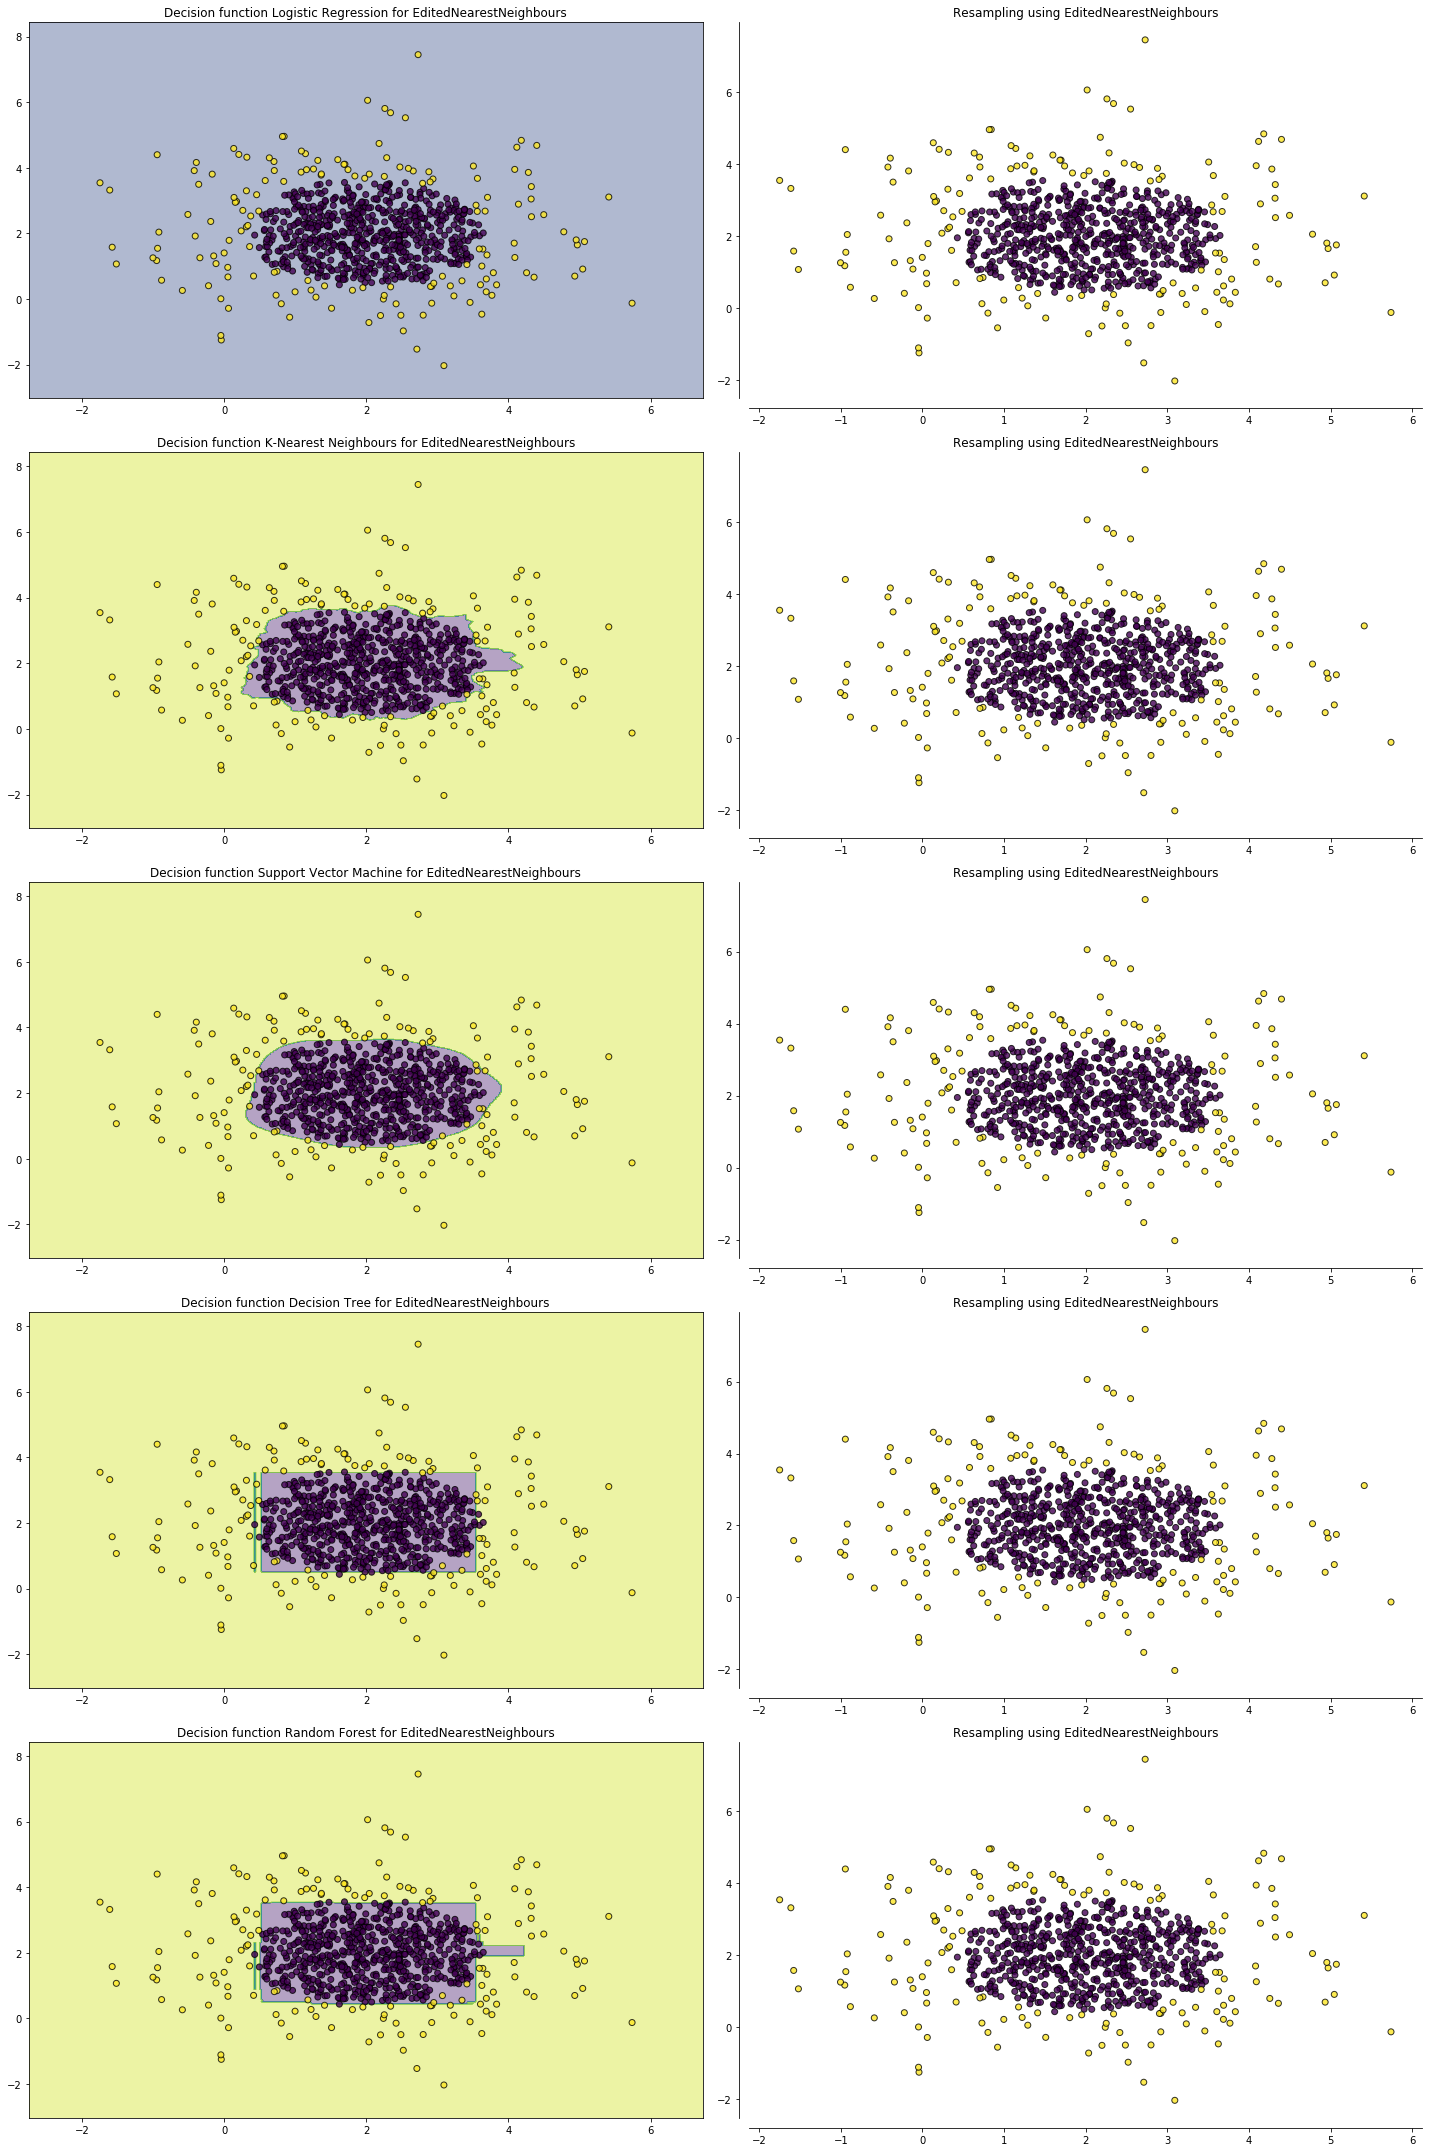

In [13]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg1, clf_knn1, clf_svm1, clf_dt1, clf_rf1)):
    clf = make_pipeline (sampler, classifier)
    clf.fit(X_enn1,y_enn1)
    
    plot_decision_function(X_enn1, y_enn1, clf, ax[0])
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X_enn1, y_enn1, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()
plt.show()

In [14]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg1 = clf_logreg1.predict(X_enn1)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_logreg1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_logreg1, labels=np.unique(y_pred_logreg1))))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_logreg1, labels=np.unique(y_pred_logreg1))))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_logreg1)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#KNearest Neighbor
y_pred_knn1 = clf_knn1.predict(X_enn1)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_knn1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_knn1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_knn1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_knn1)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#SVM
y_pred_svm1 = clf_svm1.predict(X_enn1)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_svm1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_svm1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_svm1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_svm1)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Decision Tree
y_pred_dt1 = clf_dt1.predict(X_enn1)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_dt1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_dt1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_dt1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_dt1)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Random Forest
y_pred_rf1 = clf_rf1.predict(X_enn1)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn1, y_pred_rf1)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn1, y_pred_rf1)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn1, y_pred_rf1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_enn1, y_pred_rf1)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.96
Precision Score: 1.00
F1 Score: 0.98
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.9805806756909202

Classification Report Support Vector Machine:
Recall Score: 0.92
Precision Score: 1.00
F1 Score: 0.96
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.9574271077563381

Classification Report Decision Tree:
Recall Score: 0.96
Precision Score: 0.96
F1 Score: 0.96
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.9726117528040013

Classification Report Random Forest:
Recall Score: 0.95
Precision Score: 0.98
F1 Score: 0.96
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.9716848136503551


In [15]:
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg1 = clf_logreg1.predict(X_test1)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_logreg1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_logreg1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_logreg1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_logreg1)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#KNearest Neighbor
y_pred_knn1 = clf_knn1.predict(X_test1)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_knn1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_knn1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_knn1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_knn1)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#SVM
y_pred_svm1 = clf_svm1.predict(X_test1)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_svm1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_svm1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_svm1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_svm1)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Decision Tree
y_pred_dt1 = clf_dt1.predict(X_test1)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_dt1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_dt1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_dt1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_dt1)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

#Random Forest
y_pred_rf1 = clf_rf1.predict(X_test1)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test1, y_pred_rf1)))
print('Precision Score: {:.2f}'.format(precision_score(y_test1, y_pred_rf1)))
print('F1 Score: {:.2f}'.format(f1_score(y_test1, y_pred_rf1)))

G_mean_under_sampling_enn1 = geometric_mean_score (y_test1, y_pred_rf1)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn1)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.89
Precision Score: 1.00
F1 Score: 0.94
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.9414688716912718

Classification Report Support Vector Machine:
Recall Score: 0.86
Precision Score: 0.97
F1 Score: 0.92
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.9263369975879368

Classification Report Decision Tree:
Recall Score: 0.89
Precision Score: 0.85
F1 Score: 0.87
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.9201037490907801

Classification Report Random Forest:
Recall Score: 0.89
Precision Score: 0.87
F1 Score: 0.88
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.9231861823449955


In [16]:
from sklearn.datasets import make_circles

X2, y2 = make_circles (n_samples=2000, shuffle=True, noise =0.08, factor=0.9)
X_imb2, y_imb2 = make_imbalance (X2, y2, sampling_strategy={0:800, 1:200})

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_imb2, y_imb2, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y2)))
print ("Komponen dataset setelah imbalance = {}" .format(Counter(y_imb2)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='auto')

X_enn2, y_enn2 = sampler.fit_resample (X_train2 , y_train2)

#Train dataset dengan classifier
clf_logreg2 = LogisticRegression(C=0.1, penalty='l1')
clf_logreg2.fit(X_enn2,y_enn2)

clf_knn2 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn2.fit(X_enn2, y_enn2)

clf_svm2 = SVC(gamma=2, C=1)
clf_svm2.fit(X_enn2, y_enn2)

clf_dt2 = DecisionTreeClassifier(max_depth=5)
clf_dt2.fit(X_enn2, y_enn2)

clf_rf2 = RandomForestClassifier(max_depth=5, n_estimators=9, max_features='auto')
clf_rf2.fit(X_enn2, y_enn2)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn2)))

print ("Komponen training set = {}" .format(Counter(y_train2)))
print ("Komponen testing set = {}" .format(Counter(y_test2)))

Original Dataset = Counter({1: 1000, 0: 1000})
Komponen dataset setelah imbalance = Counter({0: 800, 1: 200})
Komponen dataset setelah undersampling = Counter({0: 413, 1: 156})
Komponen training set = Counter({0: 644, 1: 156})
Komponen testing set = Counter({0: 156, 1: 44})


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


C:\Users\Muhsin Ahadi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


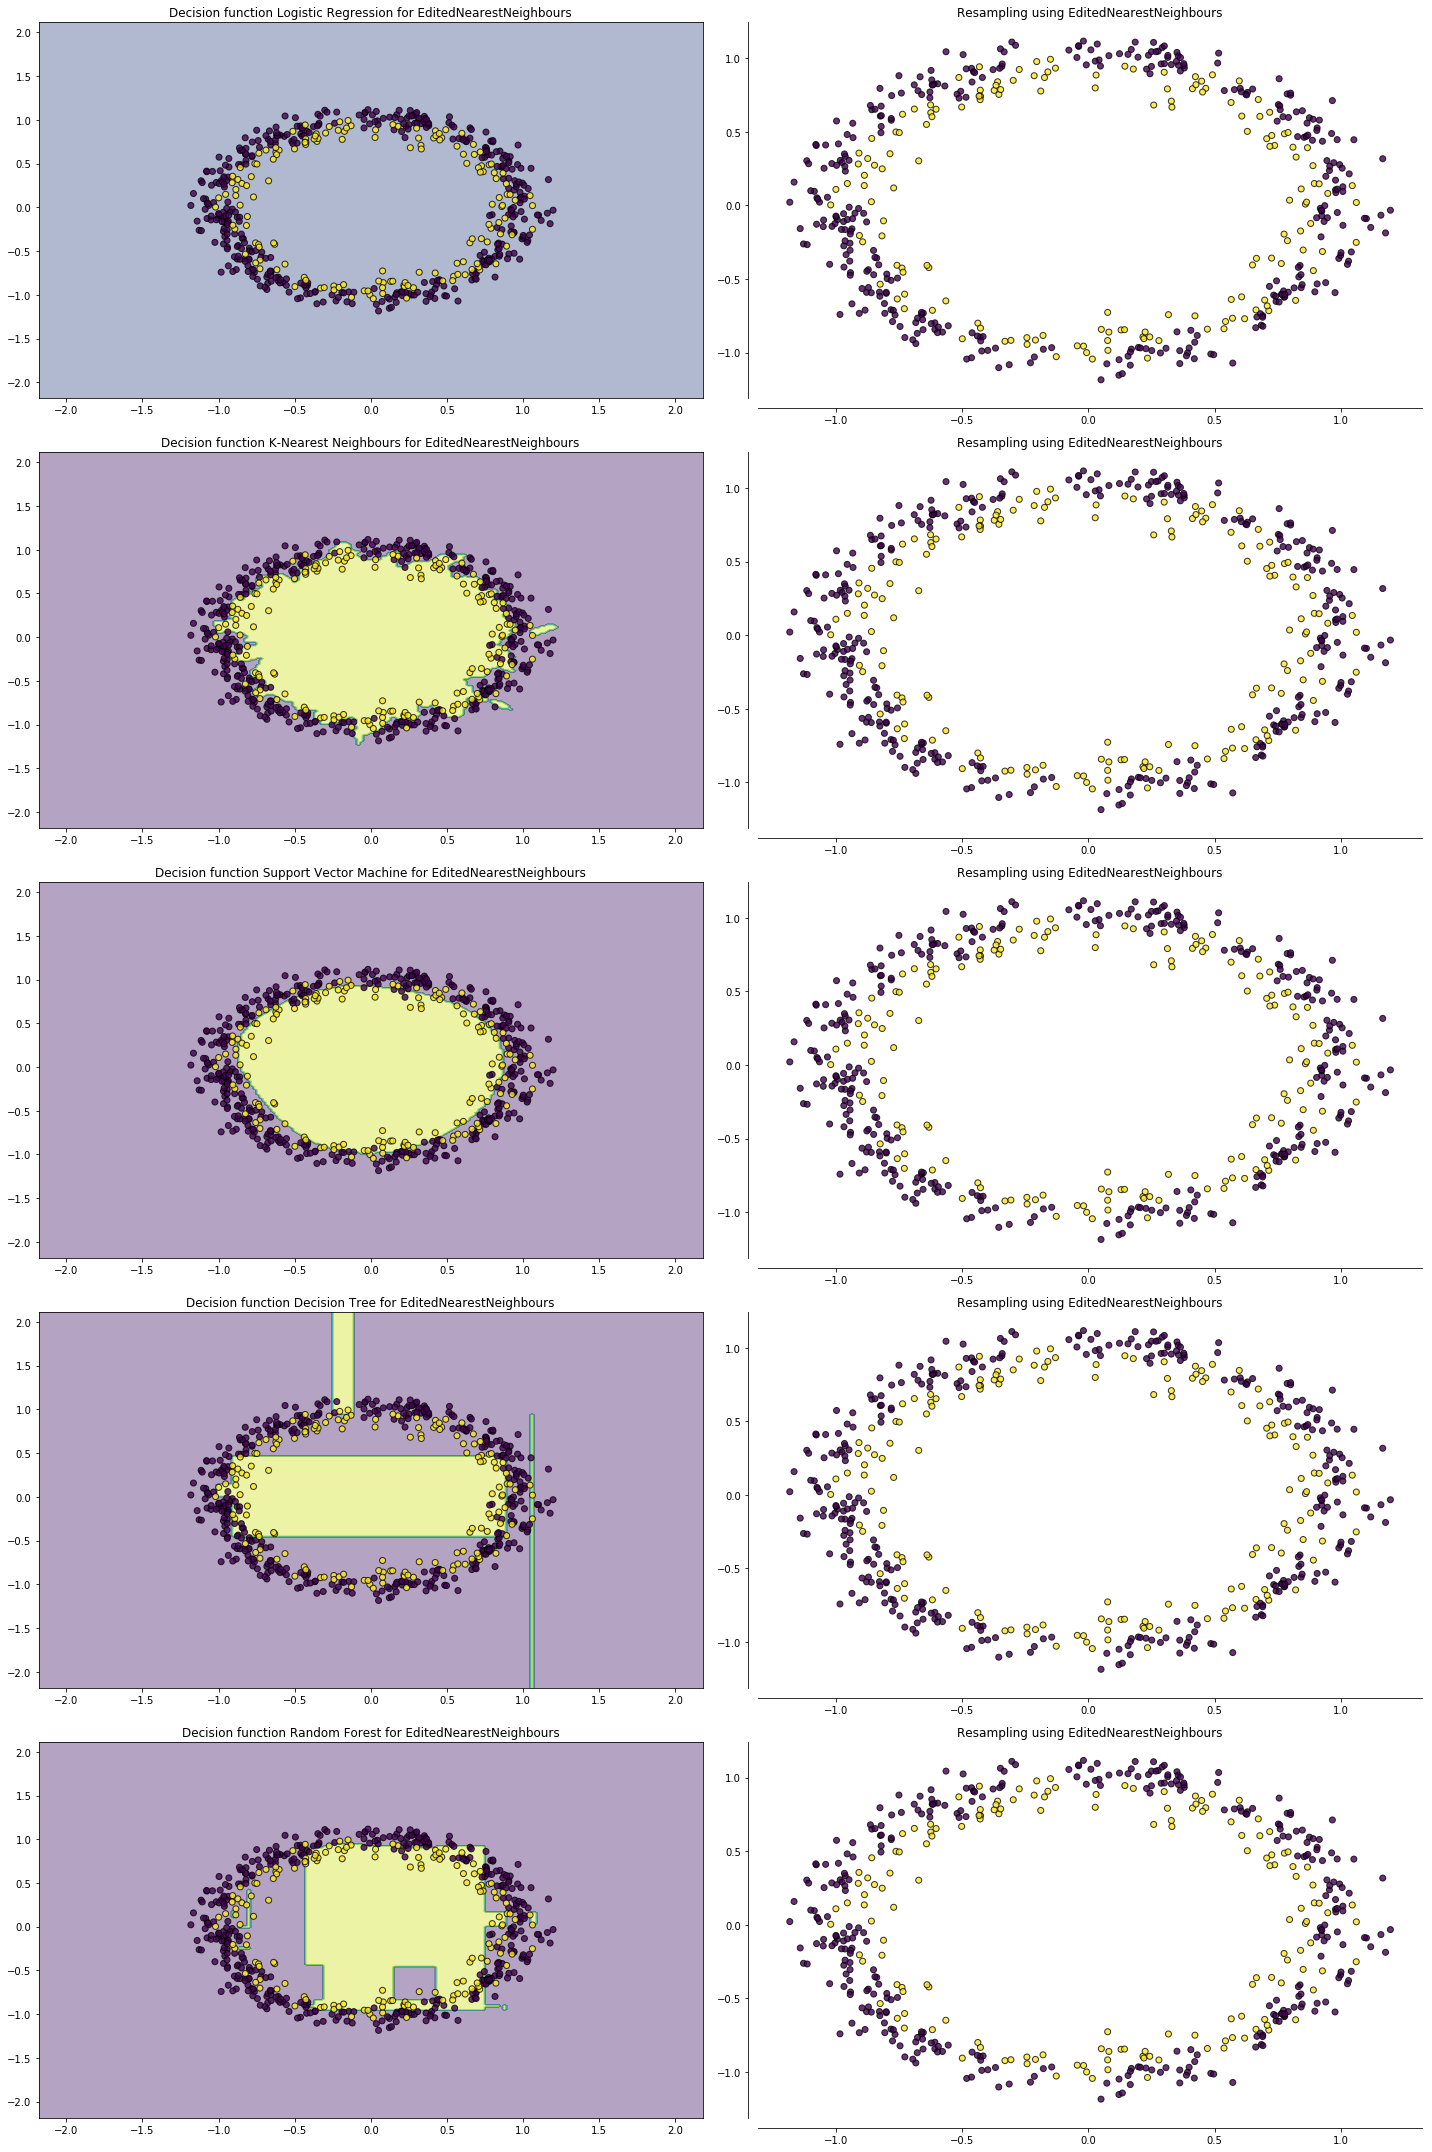

In [17]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6), (ax7,ax8), (ax9,ax10)) = plt.subplots(5,2, figsize = (20,30))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1,ax2), (ax3,ax4), (ax5,ax6), (ax7,ax8), (ax9,ax10))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg2, clf_knn2, clf_svm2, clf_dt2, clf_rf2)):
    clf = make_pipeline (sampler, classifier)
    clf.fit(X_enn2,y_enn2)
    
    plot_decision_function(X_enn2, y_enn2, clf, ax[0])
    ax[0].set_title('Decision function {} for {}'.format(name,
        sampler.__class__.__name__))
    plot_resampling(X_enn2, y_enn2, sampler, ax[1])
    ax[1].set_title('Resampling using {}'.format(
        sampler.__class__.__name__))
fig.tight_layout()
plt.show()

In [18]:
print ("Pengukuran Performa Training Set hasil ENN: \n")
y_pred_logreg2 = clf_logreg2.predict(X_enn2)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_logreg2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_logreg2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_logreg2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_logreg2)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#KNearest Neighbor
y_pred_knn2 = clf_knn2.predict(X_enn2)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_knn2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_knn2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_knn2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_knn2)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#SVM
y_pred_svm2 = clf_svm2.predict(X_enn2)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_svm2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_svm2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_svm2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_svm2)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Decision Tree
y_pred_dt2 = clf_dt2.predict(X_enn2)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_dt2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_dt2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_dt2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_dt2)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Random Forest
y_pred_rf2 = clf_rf2.predict(X_enn2)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_enn2, y_pred_rf2)))
print('Precision Score: {:.2f}'.format(precision_score(y_enn2, y_pred_rf2)))
print('F1 Score: {:.2f}'.format(f1_score(y_enn2, y_pred_rf2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_enn2, y_pred_rf2)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

Pengukuran Performa Training Set hasil ENN: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.82
Precision Score: 0.86
F1 Score: 0.84
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.8836167401596735

Classification Report Support Vector Machine:
Recall Score: 0.51
Precision Score: 0.83
F1 Score: 0.63
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.6977044196007649

Classification Report Decision Tree:
Recall Score: 0.33
Precision Score: 0.67
F1 Score: 0.44
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.5541963049513051

Classification Report Random Forest:
Recall Score: 0.54
Precision Score: 0.69
F1 Score: 0.61
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.7033763662044117


In [19]:
print ("Pengukuran Performa terhadap Testing Set: \n")

##Logistic Regression
y_pred_logreg2 = clf_logreg2.predict(X_test2)

print ('Classification Report Logistic Regression:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_logreg2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_logreg2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_logreg2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_logreg2)

print ("G-Mean untuk Logistic Regresion with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#KNearest Neighbor
y_pred_knn2 = clf_knn2.predict(X_test2)

print ('\nClassification Report K Nearest Neighbor:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_knn2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_knn2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_knn2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_knn2)

print ("G-Mean untuk K Nearest Neighbor with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#SVM
y_pred_svm2 = clf_svm2.predict(X_test2)

print ('\nClassification Report Support Vector Machine:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_svm2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_svm2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_svm2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_svm2)

print ("G-Mean untuk Support Vector Machine with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Decision Tree
y_pred_dt2 = clf_dt2.predict(X_test2)

print ('\nClassification Report Decision Tree:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_dt2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_dt2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_dt2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_dt2)

print ("G-Mean untuk Decision Tree with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

#Random Forest
y_pred_rf2 = clf_rf2.predict(X_test2)

print ('\nClassification Report Random Forest:')
print('Recall Score: {:.2f}'.format(recall_score(y_test2, y_pred_rf2)))
print('Precision Score: {:.2f}'.format(precision_score(y_test2, y_pred_rf2)))
print('F1 Score: {:.2f}'.format(f1_score(y_test2, y_pred_rf2)))

G_mean_under_sampling_enn2 = geometric_mean_score (y_test2, y_pred_rf2)

print ("G-Mean untuk Random Forest with {}: " .format(sampler.__class__.__name__) , G_mean_under_sampling_enn2)

Pengukuran Performa terhadap Testing Set: 

Classification Report Logistic Regression:
Recall Score: 0.00
Precision Score: 0.00
F1 Score: 0.00
G-Mean untuk Logistic Regresion with EditedNearestNeighbours:  0.0

Classification Report K Nearest Neighbor:
Recall Score: 0.57
Precision Score: 0.37
F1 Score: 0.45
G-Mean untuk K Nearest Neighbor with EditedNearestNeighbours:  0.6443677445448291

Classification Report Support Vector Machine:
Recall Score: 0.30
Precision Score: 0.35
F1 Score: 0.32
G-Mean untuk Support Vector Machine with EditedNearestNeighbours:  0.5

Classification Report Decision Tree:
Recall Score: 0.41
Precision Score: 0.50
F1 Score: 0.45
G-Mean untuk Decision Tree with EditedNearestNeighbours:  0.6015713689065595

Classification Report Random Forest:
Recall Score: 0.32
Precision Score: 0.27
F1 Score: 0.29
G-Mean untuk Random Forest with EditedNearestNeighbours:  0.490587393515152


In [20]:
from sklearn.datasets import make_moons

X3, y3 = make_moons (n_samples=3200, shuffle=True, noise =0.3)
X_imb3, y_imb3 = make_imbalance(X3, y3, sampling_strategy={0:1600, 1:400})
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_imb3, y_imb3, test_size = 0.2, random_state=42)

print ("Original Dataset = {}" .format(Counter(y3)))
print ("Komponen dataset sebelum undersampling = {}" .format(Counter(y_imb3)))

#Undersampling Dataset
# sampler = NearMiss(sampling_strategy="majority", version=2)
sampler = EditedNearestNeighbours(random_state = 42 , sampling_strategy='majority')

X_enn3, y_enn3 = sampler.fit_resample (X_train3 , y_train3)

#Train dataset dengan classifier
clf_logreg3 = LogisticRegression(C=0.1, penalty='l2', solver='sag')
clf_logreg3.fit(X_enn3,y_enn3)

clf_knn3 = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean')
clf_knn3.fit(X_enn3, y_enn3)

clf_svm3 = SVC(gamma=2, C=1)
clf_svm3.fit(X_enn3, y_enn3)

clf_dt3 = DecisionTreeClassifier(max_depth=5, criterion='entropy')
clf_dt3.fit(X_enn3, y_enn3)

clf_rf3 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features='auto')
clf_rf3.fit(X_enn3, y_enn3)

print ("Komponen dataset setelah undersampling = {}" .format(Counter(y_enn3)))

print ("Komponen training set = {}" .format(Counter(y_train3)))
print ("Komponen testing set = {}" .format(Counter(y_test3)))

Original Dataset = Counter({0: 1600, 1: 1600})
Komponen dataset sebelum undersampling = Counter({0: 1600, 1: 400})
Komponen dataset setelah undersampling = Counter({0: 1110, 1: 310})
Komponen training set = Counter({0: 1290, 1: 310})
Komponen testing set = Counter({0: 310, 1: 90})



^
Expected {'graph' | 'digraph'} (at char 0), (line:1, col:1)


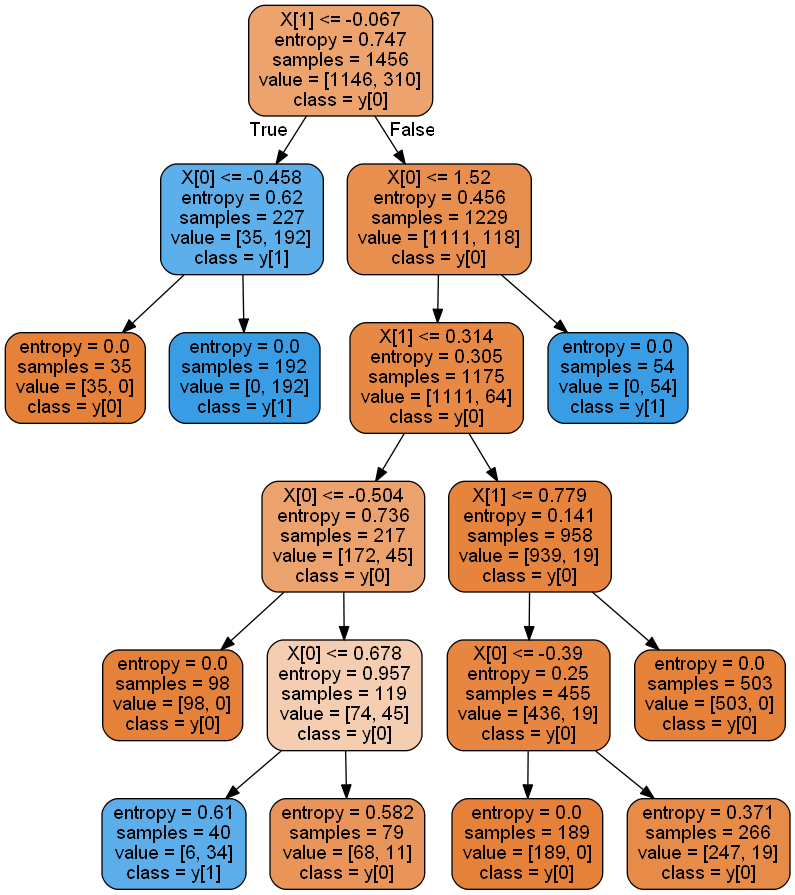

In [21]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz (clf_dt3, out_file='moon_dataset_enn.dot',
                  class_names=True,
                rounded=True, proportion=False, precision=3, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(filename = 'moon_dataset_enn.png')

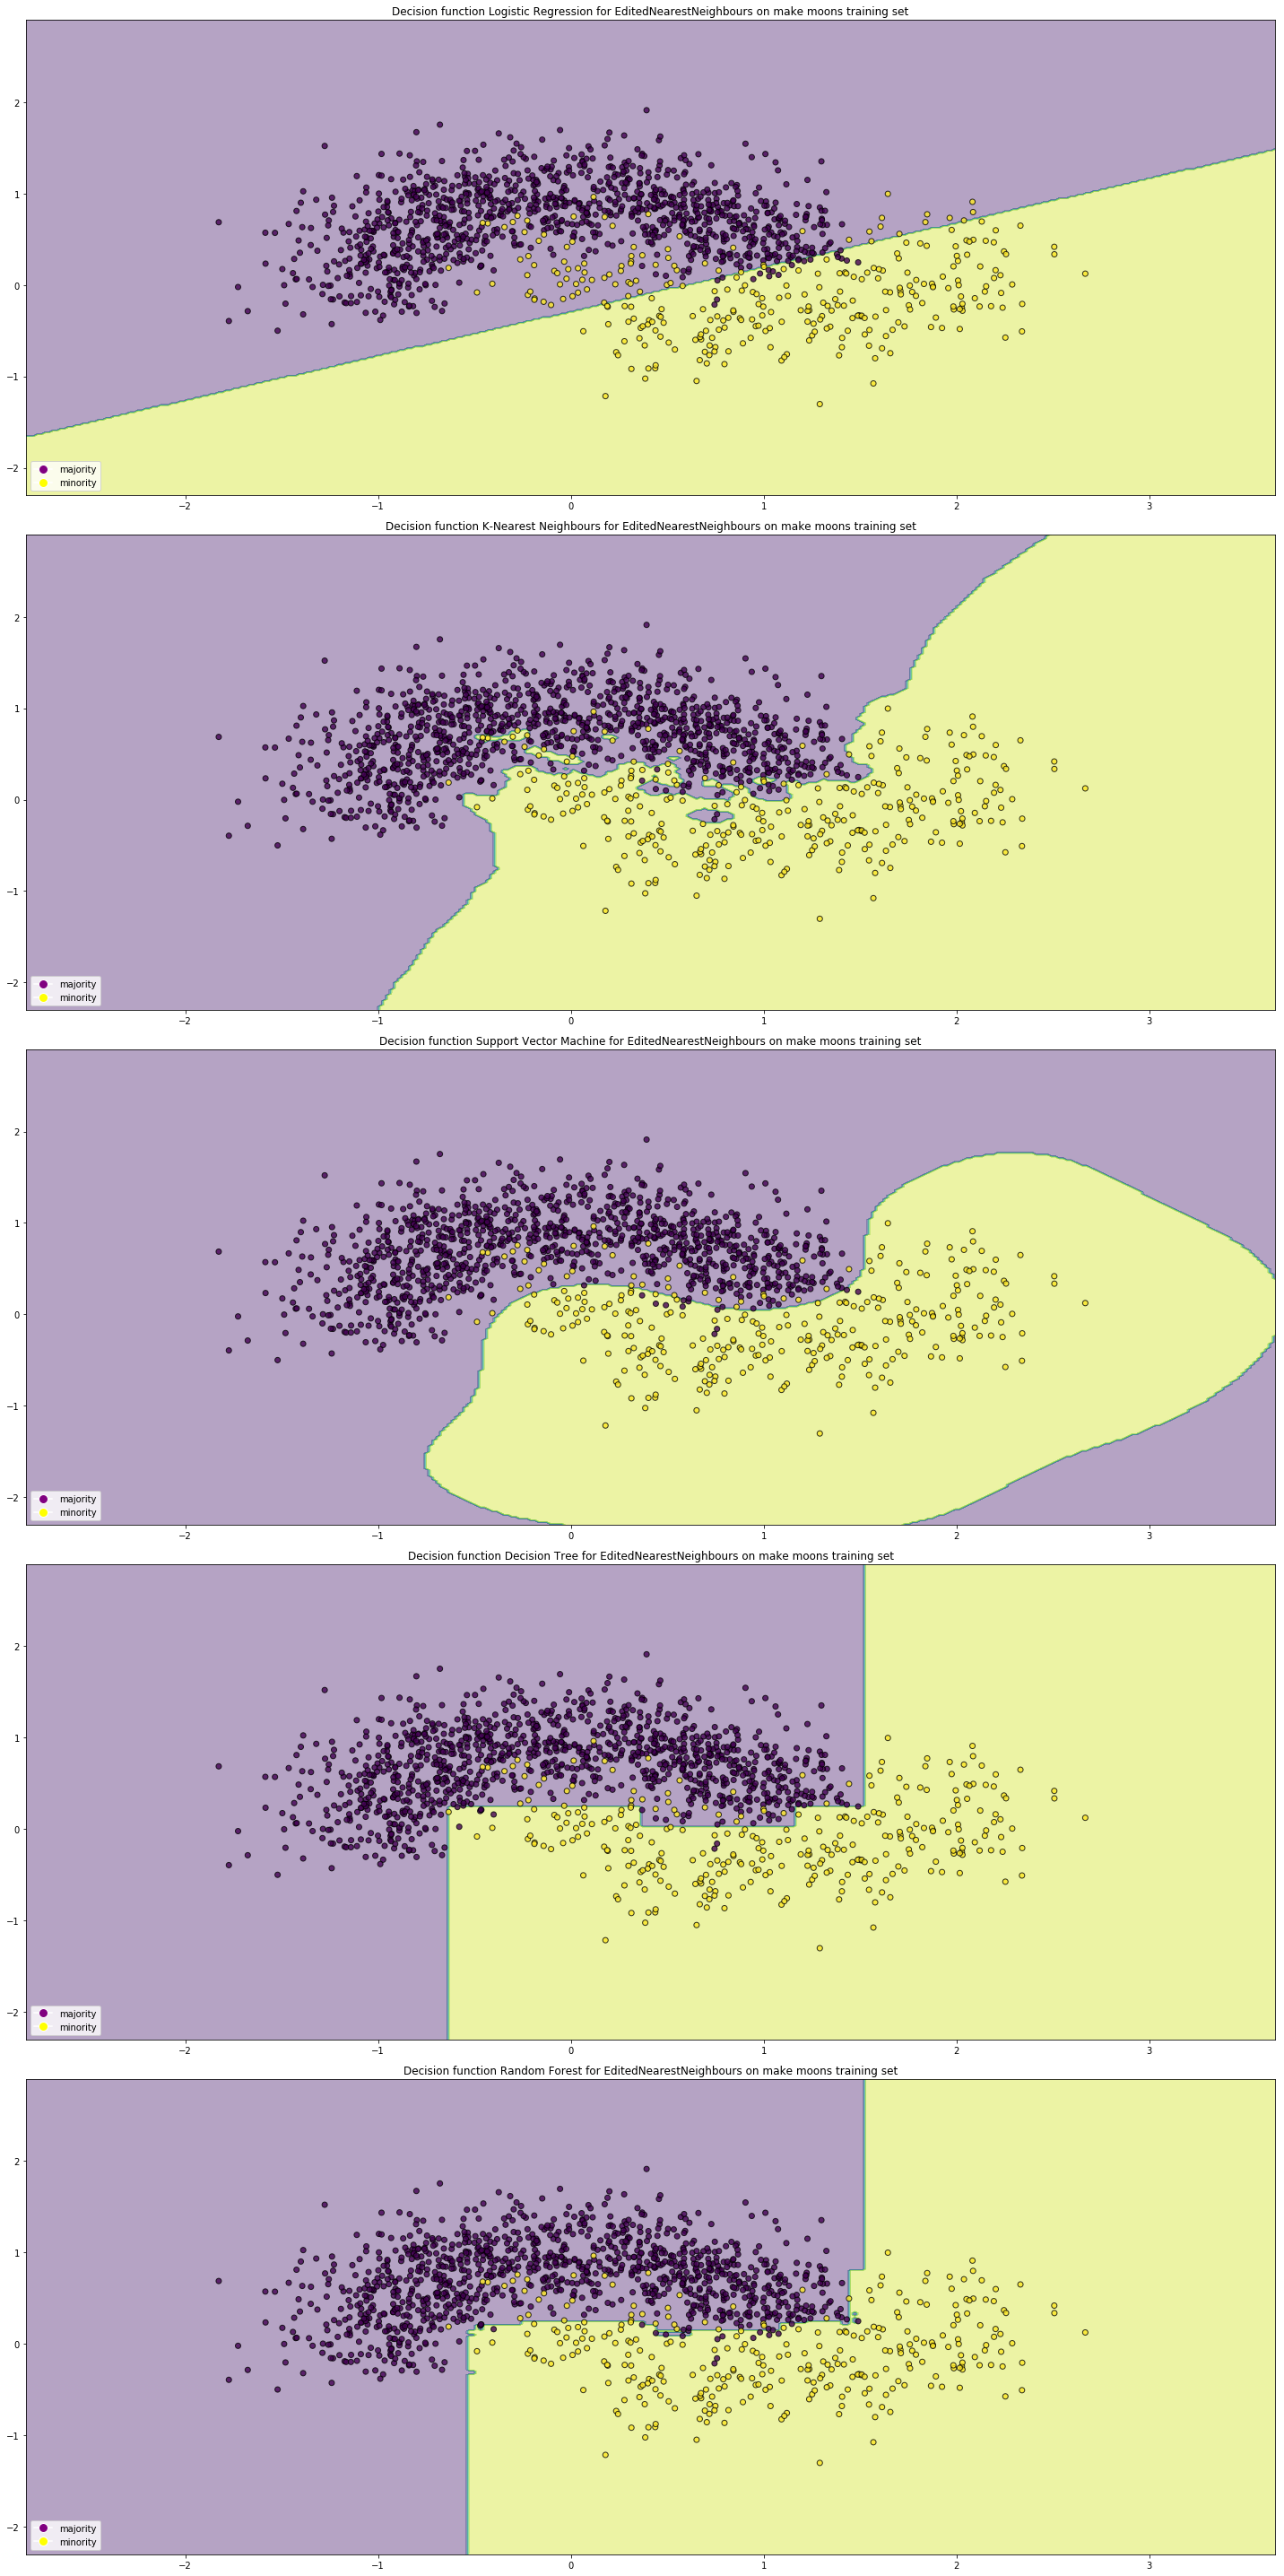

In [22]:
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg3, clf_knn3, clf_svm3, clf_dt3, clf_rf3)):
#     clf = make_pipeline (sampler, classifier)
    classifier.fit(X_enn3,y_enn3)
    plot_decision_function(X_enn3, y_enn3, classifier, ax)
#     print (y_imb3.shape)
    ax.set_title('Decision function {} for {} on make moons training set'.format(name,
        sampler.__class__.__name__))
    majority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
#     plot_resampling(X_enn3, y_enn3, sampler, ax[1])
#     ax[1].set_title('Resampling using {}'.format(
#         sampler.__class__.__name__))
fig.tight_layout()
plt.savefig("decision function make moons training set with enn.pdf")

# plt.show()

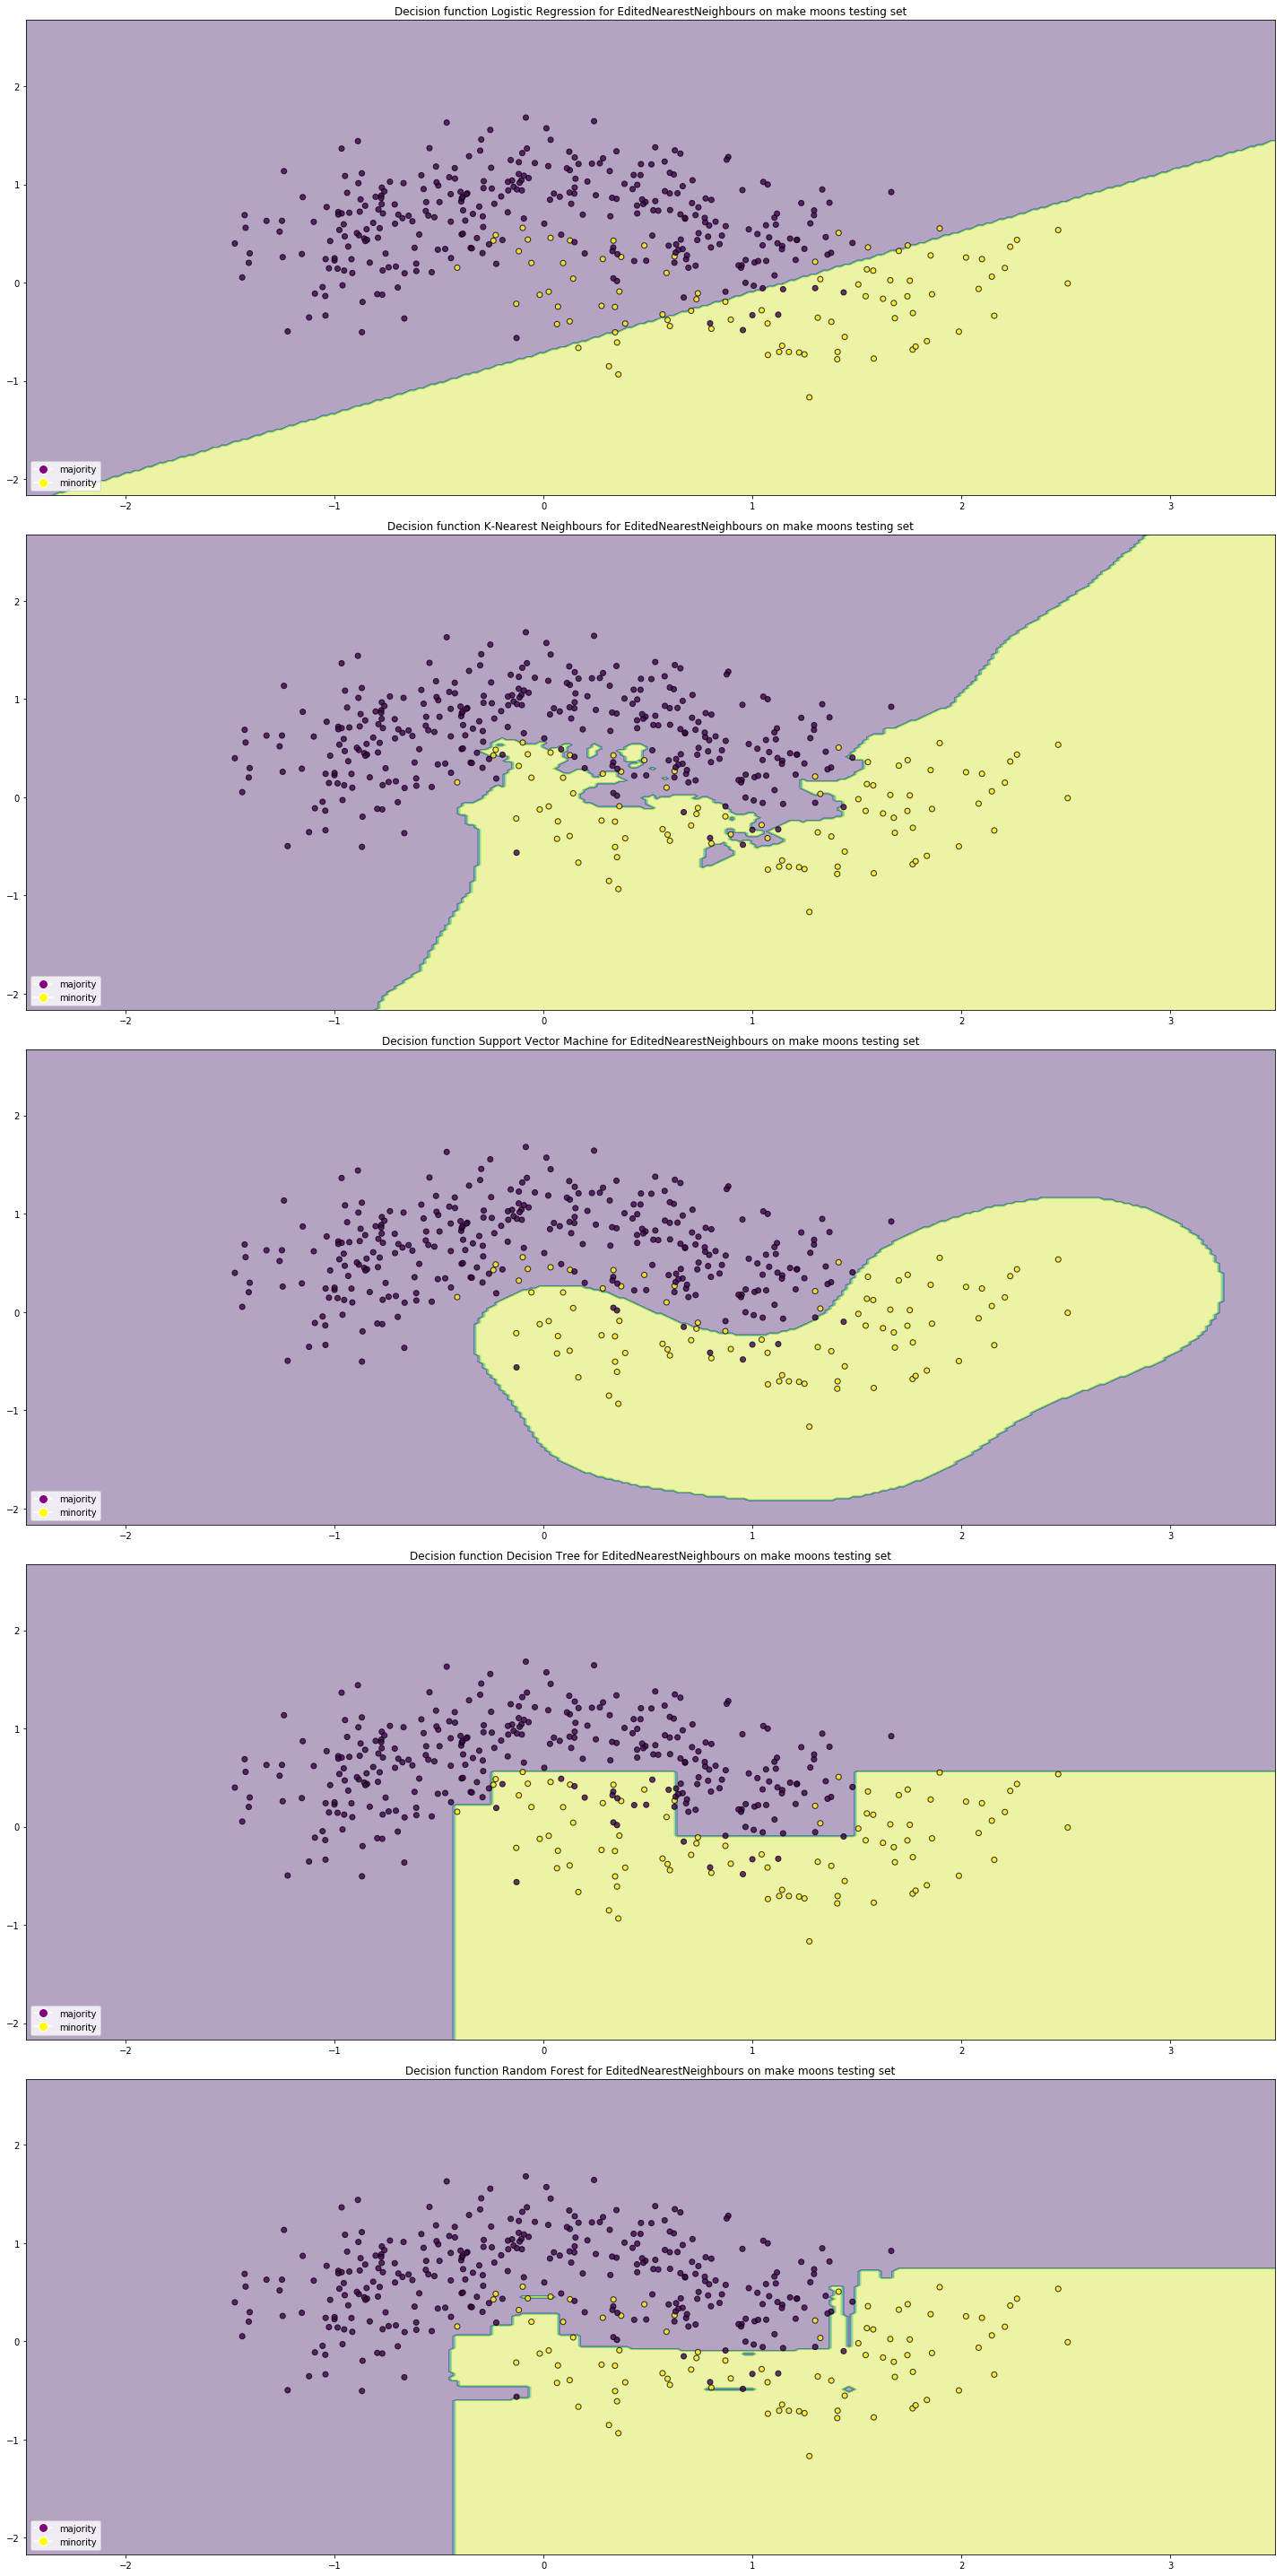

In [23]:
fig, ((ax1),(ax2),(ax3),(ax4),(ax5)) = plt.subplots(5, figsize = (20,40))

# classifiers = [clf_logreg, clf_knn]
ax_arr = ((ax1), (ax2), (ax3), (ax4), (ax5))
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]


for ax, name, classifier in zip (ax_arr, names,  (clf_logreg3, clf_knn3, clf_svm3, clf_dt3, clf_rf3)):
#     clf = make_pipeline (sampler, classifier)  
    classifier.fit(X_test3,y_test3)
    plot_decision_function(X_test3, y_test3, classifier, ax)
#     print (y_imb3.shape)
    ax.set_title('Decision function {} for {} on make moons testing set'.format(name,
        sampler.__class__.__name__))
    majority=Line2D([], [], color="w", markerfacecolor='purple', marker='o', label='majority', markersize=10)
    minority=Line2D([], [], color="w", markerfacecolor='yellow', marker='o', label='minority', markersize=10)
    ax.legend(handles=[majority,minority], loc='lower left', frameon=True)
#     plot_resampling(X_enn3, y_enn3, sampler, ax[1])
#     ax[1].set_title('Resampling using {}'.format(
#         sampler.__class__.__name__))
fig.tight_layout()
plt.savefig("decision function make moons testing set with enn.pdf")

In [24]:
print ("Pengukuran Performa Training Set hasil ENN: \n")
names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]

for classifiers, name in zip ((clf_logreg3, clf_knn3, clf_svm3, clf_dt3, clf_rf3), names):
    print ("\nHasil klasifikasi testing set {}: " .format(name))
    y_pred = classifiers.predict(X_enn3)

    print(classification_report(y_enn3, y_pred))
    
    G_mean = geometric_mean_score (y_enn3, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)

Pengukuran Performa Training Set hasil ENN: 


Hasil klasifikasi testing set Logistic Regression: 
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1110
           1       1.00      0.59      0.74       310

   micro avg       0.91      0.91      0.91      1420
   macro avg       0.95      0.80      0.84      1420
weighted avg       0.92      0.91      0.90      1420

G-Mean untuk Logistic Regression :  0.7683245282074245

Hasil klasifikasi testing set K-Nearest Neighbours: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1110
           1       0.93      0.78      0.85       310

   micro avg       0.94      0.94      0.94      1420
   macro avg       0.94      0.88      0.91      1420
weighted avg       0.94      0.94      0.94      1420

G-Mean untuk K-Nearest Neighbours :  0.8781569032031904

Hasil klasifikasi testing set Support Vector Machine: 
              precision   

In [25]:
print ("Pengukuran Performa terhadap Testing Set: \n")

names = ["Logistic Regression", "K-Nearest Neighbours", "Support Vector Machine", "Decision Tree", "Random Forest"]

for classifiers, name in zip ((clf_logreg3, clf_knn3, clf_svm3, clf_dt3, clf_rf3), names):
    print ("\nHasil klasifikasi testing set {}: " .format(name))
    y_pred = classifiers.predict(X_test3)

    print(classification_report(y_test3, y_pred))
    
    G_mean = geometric_mean_score (y_test3, y_pred)
    print ("G-Mean untuk {} : "  .format(name) , G_mean)

Pengukuran Performa terhadap Testing Set: 


Hasil klasifikasi testing set Logistic Regression: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       310
           1       0.89      0.61      0.72        90

   micro avg       0.90      0.90      0.90       400
   macro avg       0.89      0.79      0.83       400
weighted avg       0.89      0.90      0.89       400

G-Mean untuk Logistic Regression :  0.7728595137261295

Hasil klasifikasi testing set K-Nearest Neighbours: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       310
           1       0.88      0.82      0.85        90

   micro avg       0.94      0.94      0.94       400
   macro avg       0.92      0.89      0.90       400
weighted avg       0.93      0.94      0.93       400

G-Mean untuk K-Nearest Neighbours :  0.8920195764282209

Hasil klasifikasi testing set Support Vector Machine: 
              precision    r